# 导库区

In [2]:
import pandas as pd
import numpy as np
# 画图
import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
            "font.family": 'serif',
            "mathtext.fontset": 'stix', # matplotlib渲染数学字体时使用的字体，和Times New Roma
            "font.serif": ['SimSun'], # 宋体
		"font.size": 12,
            'axes.unicode_minus': False # 处理负号，即-号
            }

rcParams.update(config)
# jupyter高清
%config InlineBackend.figure_format = 'svg'

# 预处理区

In [3]:
df0 = pd.read_csv('../Mathorcup/Data/data_100.csv')
df0.head(3) 
# t：通过率  h：坏账率

,t_1,h_1,t_2,h_2,t_3,h_3,t_4,h_4,t_5,h_5,...,t_96,h_96,t_97,h_97,t_98,h_98,t_99,h_99,t_100,h_100
0,0.76,0.013,0.72,0.032,0.80,0.012,0.79,0.004,0.70,0.009,...,0.74,0.006,0.72,0.023,0.79,0.011,0.75,0.011,0.71,0.016
1,0.77,0.015,0.73,0.038,0.82,0.013,0.80,0.007,0.76,0.015,...,0.76,0.017,0.77,0.037,0.81,0.015,0.77,0.013,0.78,0.024
2,0.78,0.017,0.76,0.050,0.83,0.024,0.81,0.011,0.77,0.025,...,0.80,0.040,0.80,0.043,0.83,0.023,0.80,0.020,0.80,0.028


In [4]:
# 根据数据性质，无需检查重复、异常与标准化
# 无缺失值，其实也是显然的，因为这数据是人为规定的，有缺失就做不了了，论文中可以不必要写这一步
df0[df0.isna()].sum().sum()

0.0

由于原始数据的形式不便于后续编程分析，我们将它转换为100列的数据，也就是同一张评分表用一列表示即可，而不是原来的两列。

In [5]:
def fun1(lis):
    return [[lis[i],lis[i+1]] for i in range(0,200,2)]

df = df0.copy()
df['new'] = df.apply(fun1,axis=1)
df = pd.DataFrame(df['new'].to_list(),columns=[f'Card{i}' for i in range(1,101)])
df.index = df.index + 1
df.head(3) # 注意，这里的index就变成了阈值1-10了

,Card1,Card2,Card3,Card4,Card5,Card6,Card7,Card8,Card9,Card10,...,Card91,Card92,Card93,Card94,Card95,Card96,Card97,Card98,Card99,Card100
1,"[0.76, 0.013]","[0.72, 0.032]","[0.8, 0.012]","[0.79, 0.004]","[0.7, 0.009]","[0.7, 0.033]","[0.73, 0.016]","[0.79, 0.01]","[0.75, 0.01]","[0.73, 0.012]",...,"[0.76, 0.004]","[0.76, 0.012]","[0.81, 0.016]","[0.75, 0.004]","[0.71, 0.009]","[0.74, 0.006]","[0.72, 0.023]","[0.79, 0.011]","[0.75, 0.011]","[0.71, 0.016]"
2,"[0.77, 0.015]","[0.73, 0.038]","[0.82, 0.013]","[0.8, 0.007]","[0.76, 0.015]","[0.71, 0.037]","[0.74, 0.021]","[0.88, 0.013]","[0.76, 0.011]","[0.74, 0.018]",...,"[0.8, 0.008]","[0.77, 0.013]","[0.83, 0.035]","[0.77, 0.014]","[0.72, 0.015]","[0.76, 0.017]","[0.77, 0.037]","[0.81, 0.015]","[0.77, 0.013]","[0.78, 0.024]"
3,"[0.78, 0.017]","[0.76, 0.05]","[0.83, 0.024]","[0.81, 0.011]","[0.77, 0.025]","[0.73, 0.042]","[0.75, 0.022]","[0.89, 0.016]","[0.78, 0.015]","[0.76, 0.019]",...,"[0.85, 0.016]","[0.78, 0.016]","[0.84, 0.042]","[0.78, 0.018]","[0.73, 0.049]","[0.8, 0.04]","[0.8, 0.043]","[0.83, 0.023]","[0.8, 0.02]","[0.8, 0.028]"


# 建模区

## 问题一【常规解法】（用于验证）
设

贷款资金为：$M=1000000$

银行贷款利息收入率为：$p=0.08$

使用的信用评分卡为：$c_i,c_j,c_k$，其中$i,j,k \in{\{1\leq x\leq 100,x\in N\}}$，即表示用的第$ijk$张信用评分卡

对应的总通过率与总通过率为：$t,t_1,t_2,t_3；t=t_1 t_2 t_3$

对应的总坏账率与总坏账率为：$p,p_1,p_2,p_3；p=(p_1+p_2+p_3)/3$

贷款利息收入为：$I=Mpt(1-h)$

坏账损失为：$L=Mth$

最终收入为：$\omega = I-L = Mpt(1-h)-Mth = Mt(p-(1+p)h)$

此时，我们只需要画出$\omega \sim t,h$的曲线，并根据所以的信用评分表，即可算出最优的结果

In [6]:
# 查看评分表中t、h的范围
datas = list(df0.to_numpy().flatten())
t_max = max(i for i in datas if i >0.5)
t_min = min(i for i in datas if i >0.5)
h_max = max(i for i in datas if i <0.5)
h_min = min(i for i in datas if i <0.5)
print(f't：{t_min}-{t_max}')
print(f'h：{h_min}-{h_max}')

t：0.7-0.99
h：0.003-0.088


<Figure size 640x480 with 0 Axes>

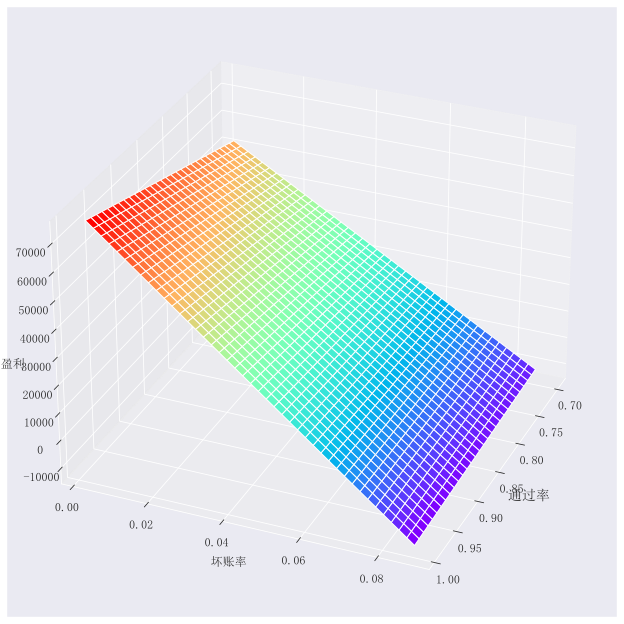

In [40]:
# 画出利润曲线图
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

m = 1000000
p = 0.08

t = np.arange(0.7,0.99,0.01)
h = np.arange(0.003,0.088,0.001)

fig = plt.figure()
fig = plt.figure(figsize=(11, 11))
# fig = plt.figure(figsize=(10, 8))
ax3 = plt.axes(projection='3d')

#定义三维数据
t = np.arange(0.7,0.99,0.01)
h = np.arange(0.003,0.088,0.001)
# X和Y轴 作用是从给定的一维数组t和h创建一个二维坐标网格。生成的X和Y数组具有相同的形状，并包含t和h中对应元素的所有可能组合
X, Y = np.meshgrid(t, h)

# 利息
Z = m*X*(p-(1+p)*Y)

#作图
ax3.plot_surface(X,Y,Z,cmap='rainbow')
# 作图
#ax3.plot_trisurf(X.flatten(), Y.flatten(), Z.flatten(), cmap='rainbow')

ax3.set_xlabel('通过率',fontsize=14) #X
ax3.tick_params(axis='x', labelsize=12)
ax3.set_ylabel('坏账率') #Y
ax3.set_zlabel('盈利')#Z
#elev参数表示从水平面看垂直方向的旋转角度，azim参数表示从xz平面看x轴正半轴的旋转角度
ax3.view_init(elev=29, azim=23)
# plt.tight_layout()
#plt.savefig('./figs/w-t_h.png',dpi=800)

这个时候我们能很明显的看出不同的通过率坏账率组合对应的盈利，然后将题目所给表的数据代入计算即可。

In [41]:
df.head(3)

,Card1,Card2,Card3,Card4,Card5,Card6,Card7,Card8,Card9,Card10,...,Card91,Card92,Card93,Card94,Card95,Card96,Card97,Card98,Card99,Card100
1,"[0.76, 0.013]","[0.72, 0.032]","[0.8, 0.012]","[0.79, 0.004]","[0.7, 0.009]","[0.7, 0.033]","[0.73, 0.016]","[0.79, 0.01]","[0.75, 0.01]","[0.73, 0.012]",...,"[0.76, 0.004]","[0.76, 0.012]","[0.81, 0.016]","[0.75, 0.004]","[0.71, 0.009]","[0.74, 0.006]","[0.72, 0.023]","[0.79, 0.011]","[0.75, 0.011]","[0.71, 0.016]"
2,"[0.77, 0.015]","[0.73, 0.038]","[0.82, 0.013]","[0.8, 0.007]","[0.76, 0.015]","[0.71, 0.037]","[0.74, 0.021]","[0.88, 0.013]","[0.76, 0.011]","[0.74, 0.018]",...,"[0.8, 0.008]","[0.77, 0.013]","[0.83, 0.035]","[0.77, 0.014]","[0.72, 0.015]","[0.76, 0.017]","[0.77, 0.037]","[0.81, 0.015]","[0.77, 0.013]","[0.78, 0.024]"
3,"[0.78, 0.017]","[0.76, 0.05]","[0.83, 0.024]","[0.81, 0.011]","[0.77, 0.025]","[0.73, 0.042]","[0.75, 0.022]","[0.89, 0.016]","[0.78, 0.015]","[0.76, 0.019]",...,"[0.85, 0.016]","[0.78, 0.016]","[0.84, 0.042]","[0.78, 0.018]","[0.73, 0.049]","[0.8, 0.04]","[0.8, 0.043]","[0.83, 0.023]","[0.8, 0.02]","[0.8, 0.028]"


可以看出，选用第49张信用评分卡且使用第一档阈值时（t=0.82,h=0.005），其最终收入最多，最终收入为61172。

## 问题一【QUBO解法】（题目指定）

In [54]:
def fun2(x,y):
    return m*x*(p-(1+p)*y) #Z = m*X*(p-(1+p)*Y) = 利息
# sourcery skip: use-itertools-product

Data = []
for j in range(1,101):#100个评分信用卡
    for i in range(1,11):#每张评分信用卡里面有十个t和h
        th = df.iloc[i-1,j-1]#每次内循环之后，都会获取每一个组合的所有数据,比如第一次内循环会获取第一个信用评分卡的组合数据
        Data.append([j,i]+th)#[0,0]+th = [0,0,0.76,0.013] #规范数据格式[‘评分卡序号’,'阈值','通过率','坏账率']
df_w = pd.DataFrame(Data,columns=['Card','Threshold','t','h'])#把所有数据以此格式放入df_w中,并转为DataFrame格式(DataFrame是一种二维的数据结构，类似于电子表格或SQL表格)
print(df_w)
'''
df_w.apply(lambda x: fun2(x[2],x[3]),axis=1)的作用是对DataFrame的每一行应用函数fun2，计算并返回相应的结果。其中，
lambda x: fun2(x[2],x[3])定义了一个匿名函数，它接受一个Series对象x（代表DataFrame的一行数据），
并返回fun2函数对x的第3个和第4个元素（即't'和'h'列）进行计算的结果。axis=1参数指定对每一行应用函数，而不是对每一列应用函数。

具体来说，该代码会在df_w的每一行上计算't'和'h'列的值，将它们作为参数传递给函数fun2，然后将fun2的返回值赋值给'w'列。
这样，DataFrame中的每一行都将包含一个名为'w'的新列，其值是根据't'和'h'列计算得出的盈利结果。
'''
df_w['w'] = df_w.apply(lambda x: fun2(x[2],x[3]),axis=1)#定义df_w['w']，w作为标签，代表盈利的意思,

'''
作用是对DataFrame对象df_w中的数据按照'w'列进行降序排列，即将'w'列的值从大到小排序。其中，sort_values()函数是Pandas库中用于排序的函数，参数'w'指定了按照'w'列进行排序，
ascending=0表示降序排列，ascending=1则表示升序排列。
'''
df_w = df_w.sort_values('w',ascending=0)
df_w.head(5)

     Card  Threshold     t      h
0       1          1  0.76  0.013
1       1          2  0.77  0.015
2       1          3  0.78  0.017
3       1          4  0.80  0.024
4       1          5  0.82  0.026
..    ...        ...   ...    ...
995   100          6  0.86  0.052
996   100          7  0.87  0.053
997   100          8  0.88  0.064
998   100          9  0.90  0.069
999   100         10  0.91  0.084

[1000 rows x 4 columns]


,Card,Threshold,t,h,w
480,49,1,0.82,0.005,61172.0
481,49,2,0.83,0.006,61021.6
30,4,1,0.79,0.004,59787.2
531,54,2,0.78,0.004,59030.4
482,49,3,0.85,0.010,58820.0


In [9]:
unique_t = {i for i in datas if i >0.5}
unique_h = {i for i in datas if i <0.5}
len(unique_t),len(unique_h) # 这里取值分别为30，86个，意味着我们最后需要将这两个变量转化为116个二元变量

(30, 86)

QUBO介绍

QUBO 模型是指二次无约束二值优化（Quadratic Unconstrained Binary Optimization）模型

它是一种用于解决组合优化问题的数学模型

在QUBO模型中，需要将问题转化为一个决策变量为二值变量，目标函数是一个二次函数形式优化模型

首先，需要将原始的两个自变量t、h，分别转换为二元变量

t：（30个取值，从0.7，每隔0.01，到0.99）

h：（86个取值，从0.003，每隔0.008，到0.088）

原理如下：班级取值有1，2，3班，将这个变量分解为三个变量x1,x2,x3，如果是1班，那么对应取值为100，如果是3班，对应取值为001，其他的类推。

但是30×86>10×100，这使得最后的结果（t、h的组合并不在100张评分表中），所以意味着我们最后可能需要将这两个变量用1000个二元变量来表示（表的数量100*阈值的个数10）

假定我们选取的是第j张信用表的第i个阈值，$x_{ij}=1，x_{mn}=0(m\neq i,n\neq j)$

$x_{ij}$对应的t系数取其原有的数值记为$\alpha_{ij}$，对应的h系数取其原有的数值记为$\beta_{ij}$


此时我们原生的两个变量可写为
$$ t = \sum \sum{\alpha_{ij} x_{ij}} $$
$$ h = \sum \sum{\beta_{ij} x_{ij}} $$

又最终收入为：$\omega = I-L = Mpt(1-h)-Mth = Mt(p-(1+p)h)$

不考虑M的影响，等价于最大化下面的式子
$$ Max(Z) = t(p-(1+p)h) = (\sum \sum{\alpha_{ij} x_{ij}}) \cdot (p-(1+p) \cdot (\sum \sum{\beta_{ij} x_{ij}})) $$
其中，自变量为$x_{ij} \in \{0,1\}, i\in [1,10],j \in [1,100]$且
$$ \sum \sum{x_{ij}}=1$$

或将约束加入目标：（通过添加约束项，并设置较大的系数P保证约束内容的优先级）
$$ Max(Z^{'}) = (\sum \sum{\alpha_{ij} x_{ij}}) \cdot (p-(1+p) \cdot (\sum \sum{\beta_{ij} x_{ij}})) - P(\sum \sum{x_{ij}})^2$$

此时，我们已经将问题转化为二元问题了，下面将此问题利用QUBO编程求解即可。

## 问题二【QUBO解法】

此时，相对于第一问，这里增加了两张评分卡，仅需要将三个评分卡的总通过率和坏账率计算出来，然后带入第一问的模型即可。

首先，已经确定是使用的123张评分卡，那么$j_1,j_2,j_3=1,2,3$

假定三个评分卡选取的阈值依次是第$i_1,i_2,i_3 \in [1,10]$，$x_{i_k j_k}=1，x_{mn}=0(m\neq i_k,n\neq j_k),k=\{1,2,3\}$

$x_{i j}$对应的t系数取其原有的数值记为$\alpha_{i j}$，对应的h系数取其原有的数值记为$\beta_{i j}$

可知
$$ t_{j_k} = \sum_{i=1}^{10}{\alpha_{i,j_k} x_{i,j_k}}, k=1,2,3$$
$$ t = t_{j_1}t_{j_2}t_{j_3} = \sum_{i=1}^{10}{\alpha_{i,j_1} x_{i,j_1}} \cdot \sum_{i=1}^{10}{\alpha_{i,j_2} x_{i,j_2}} \cdot \sum_{i=1}^{10}{\alpha_{i,j_3} x_{i,j_3}}$$
$$ h_{j_k} = \sum_{i=1}^{10}{\beta_{i,j_k} x_{i,j_k}}, k=1,2,3$$
$$ h = (\sum_{k=1}^{3} h_{j_k})/3 = (\sum_{k=1}^{3} \sum_{i=1}^{10}{\beta_{i,j_k} x_{i,j_k}})/3$$

又最终收入为：$\omega = I-L = Mpt(1-h)-Mth = Mt(p-(1+p)h)$

不考虑M的影响，等价于最大化下面的式子
$$ Max(Z) = t(p-(1+p)h)$$

同理上问，下面将此问题利用QUBO编程求解即可。（但是这里其实有个问题，因为根据题目所说的，总通过率是按三者乘积，这导致最后的目标成了四次多项式，而QUBO是针对2次的，这个问题大家自己看看怎么解决吧，第三问就用将这里的$j_1,j_2,j_3 \in [1,100]$即可）